Parse the profiler output to compare input rows and op times for GPU top N operations.

In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

profile_dirs = ["/opt/data/profiles/dataproc-gpu-sf100",
                "/opt/data/profiles/dataproc-gpu-sf3k",
                "/opt/data/profiles/dataproc-gpu-sf5k",
                "/opt/data/profiles/dataproc-gpu-sf10k"]
scale_factors = ["100", "3K", "5K", "10K"]

In [14]:
num_scale_factors = len(profile_dirs)
input_rows = [[] for _ in range(num_scale_factors)]
op_times = [[] for _ in range(num_scale_factors)]
for i, profile_dir in enumerate(profile_dirs):
    apps = os.listdir(profile_dir)
    apps.sort()
    for app in apps:
        print(f"Processing gpu profile {profile_dir}/{app}")
        sql_info = pd.read_csv(f"{profile_dir}/{app}/sql_plan_metrics_for_application.csv")
        condition = (sql_info['nodeName'] == 'GpuTopN')
        filtered = sql_info[condition]
        grouped = filtered.groupby("nodeID")
        for _, group in grouped:
            input_rows_for_op = 0
            op_time_for_op = 0
            for row in group.itertuples():
                if row.name == "input rows":
                    input_rows_for_op = row.total
                elif row.name == "op time":
                    op_time_for_op = row.total / 1000000.
            if input_rows_for_op != 0 and op_time_for_op != 0:
                input_rows[i].append(input_rows_for_op)
                op_times[i].append(op_time_for_op)
print([len(x) for x in input_rows])
print([len(x) for x in op_times])

Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0404
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0405
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0406
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0407
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0408
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0409
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0410
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0411
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0412
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268529525_0413
Processing gpu profile /opt/data/profiles/dataproc-gpu-sf100/application_1702268

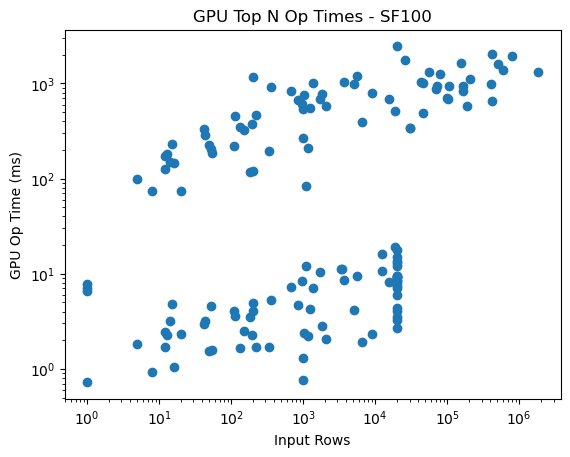

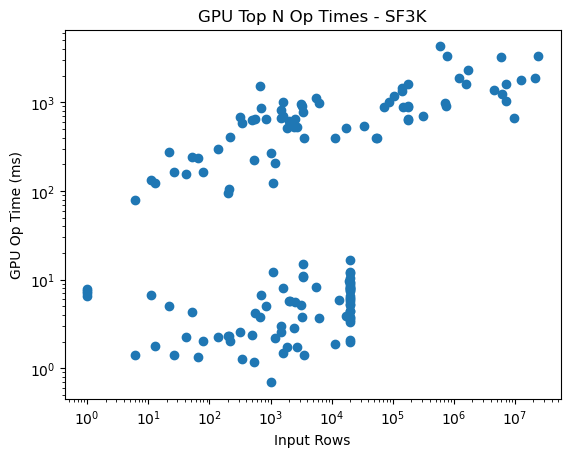

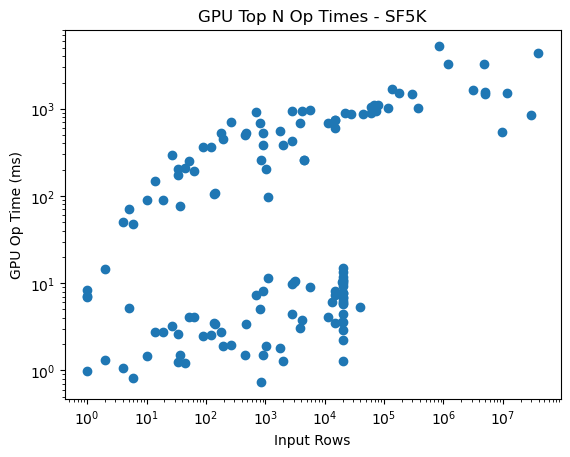

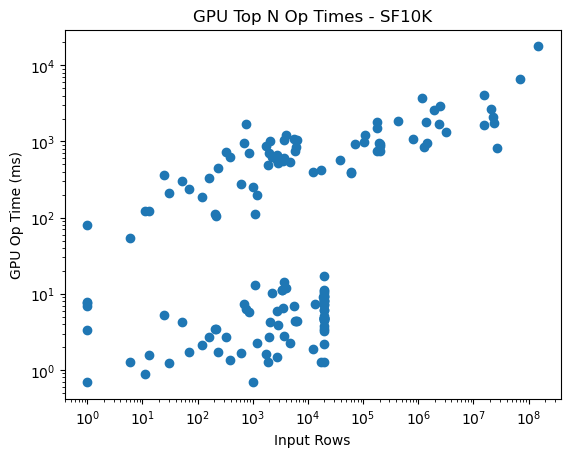

In [15]:
for i in range(num_scale_factors):
    # Create a scatter plot
    plt.scatter(input_rows[i], op_times[i])
    plt.xscale('log')
    plt.yscale('log')
    
    # Adding title and labels (optional)
    plt.title(f"GPU Top N Op Times - SF{scale_factors[i]}")
    plt.xlabel("Input Rows")
    plt.ylabel("GPU Op Time (ms)")
    
    # Show the plot
    plt.show()

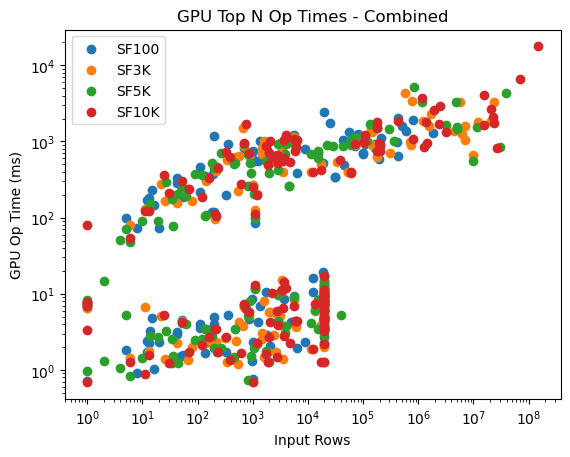

In [16]:
for i in range(num_scale_factors):
    plt.scatter(input_rows[i], op_times[i], label=f"SF{scale_factors[i]}")

plt.xscale('log')
plt.yscale('log')
plt.title("GPU Top N Op Times - Combined")
plt.xlabel("Input Rows")
plt.ylabel("GPU Op Time (ms)")
plt.legend()

# Show the plot
plt.show()